[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/07.dimensionality-reduction/b.svd-and-classification.ipynb)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

!pip install regressors
from regressors import stats # To print information about 
                            # regression.
        
from sklearn.pipeline import make_pipeline
        
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler


# May not work in the old versions of scikit-learn
from sklearn.metrics import plot_confusion_matrix  

from imblearn.over_sampling import SMOTE

# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat

--2020-05-12 04:48:06--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py.1’

visualization.py.1  100%[===================>]  12.70K  --.-KB/s    in 0s      

2020-05-12 04:48:06 (109 MB/s) - ‘visualization.py.1’ saved [13008/13008]



In [0]:
savefigures=False

Download the dataset from my github

In [4]:
dataset_to_use = 'A'
mydatasets_folder = "https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/"
filename = "df."+ dataset_to_use+"_2.csv"
complete_name = mydatasets_folder+filename
!wget $complete_name


--2020-05-12 04:48:07--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/processed_datasets/requet/df.A_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315832 (308K) [text/plain]
Saving to: ‘df.A_2.csv’

df.A_2.csv          100%[===================>] 308.43K  1.32MB/s    in 0.2s    

2020-05-12 04:48:07 (1.32 MB/s) - ‘df.A_2.csv’ saved [315832/315832]



In [0]:
df = pd.read_csv(filename)

In [6]:
print("The resolutions found in our dataset are")
set(df['label_num'].values)

The resolutions found in our dataset are


{144, 240, 360, 480, 720, 1080}

How many samples in each class?

In [7]:
df['label_num'].value_counts()

720     92
480     63
1080    55
360     33
144     27
240     22
Name: label_num, dtype: int64

# Binary classification

We want to infer whether the resolution of the transmitted video is low (<=240) or high (>=360)

In [8]:
high_res = df['label_num']>=720
high_res.head()

0    False
1    False
2     True
3    False
4    False
Name: label_num, dtype: bool

Convert into `int`

In [9]:
high_res = high_res.astype(np.int)
high_res.head()

0    0
1    0
2    1
3    0
4    0
Name: label_num, dtype: int64

Let's add it to the dataframe

In [0]:
df['high_res'] = high_res

In [0]:
df_train,df_test = train_test_split(df, test_size=0.2, random_state=1)

columns = ['BytesReceived0', 'PacketsSent0']

X_train = df_train[columns]
X_test = df_test[columns]
y_train = df_train['high_res']
y_test = df_test['high_res']

Logistic regression adds by default a regularization with weight `C`>0.
Let's try with no regularization first

In [12]:
model = LogisticRegression(C=1e-9)
model.fit(X_train, y_train)

LogisticRegression(C=1e-09, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
y_pred_proba = model.predict_proba(X_test)
y_pred_proba

array([[0.42748436, 0.57251564],
       [0.45211939, 0.54788061],
       [0.40498133, 0.59501867],
       [0.42705787, 0.57294213],
       [0.46802996, 0.53197004],
       [0.5       , 0.5       ],
       [0.45635394, 0.54364606],
       [0.43421147, 0.56578853],
       [0.44159467, 0.55840533],
       [0.49573093, 0.50426907],
       [0.44854129, 0.55145871],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       [0.44266093, 0.55733907],
       [0.48292983, 0.51707017],
       [0.48932869, 0.51067131],
       [0.39792715, 0.60207285],
       [0.47973237, 0.52026763],
       [0.45211892, 0.54788108],
       [0.5       , 0.5       ],
       [0.43329908, 0.56670092],
       [0.47760179, 0.52239821],
       [0.47653727, 0.52346273],
       [0.46802549, 0.53197451],
       [0.40716638, 0.59283362],
       [0.48719528, 0.51280472],
       [0.5       , 0.5       ],
       [0.42167345, 0.57832655],
       [0.5       , 0.5       ],
       [0.42370421, 0.57629579],
       [0.

`y_pred_proba` has two values:
* $\mathbb{P}(\mathbf{x}\notin \text{class }1)$
* $\mathbb{P}(\mathbf{x}\in \text{class }1)$

They sum up to 1.

The actual prediction is

In [14]:
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Let's have a look at the predictions vs. the true value

In [15]:
pd.DataFrame({'true':y_test, 'pred':y_pred })

,true,pred
132,0,1
267,0,1
266,1,1
62,1,1
110,1,1
27,1,0
91,0,1
189,1,1
85,1,1
164,1,1


Let's evaluate the goodness of our classifier

In [16]:
accuracy_score(y_test, y_pred)

0.4406779661016949

### Normalization

Very bad. Our classifier is just a random guess!

Let' first normalize. Normalization is important every time you use a sigmoid (as in Logistic Regression).

In [0]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [0]:
model = LogisticRegression(C=1)
model.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

In [19]:
accuracy_score(y_pred, y_test)

0.7627118644067796

Better.

## Decision boundary

Let's plot our dataset

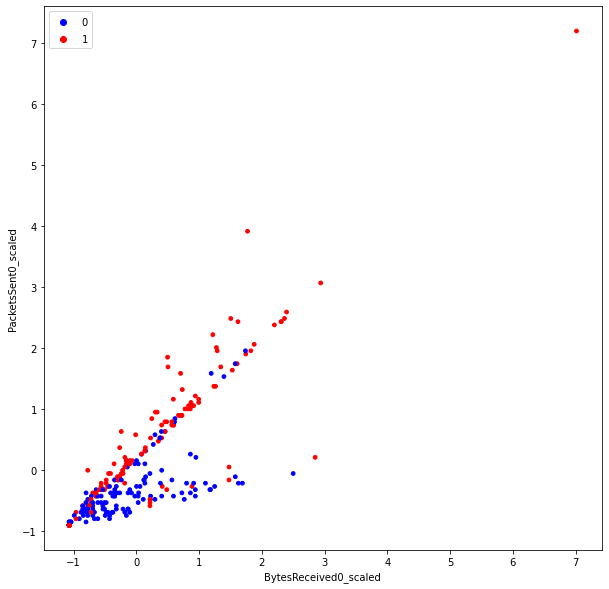

In [20]:
fig, ax = plt.subplots(figsize=(10,10) )

X = df[columns]

X_scaled = scaler.transform(X)

BytesReceived0_scaled = X_scaled[:,0]
PacketsSent0_scaled = X_scaled[:,1]

scatter = ax.scatter(BytesReceived0_scaled, PacketsSent0_scaled,
          c=df['high_res'], cmap='bwr', s=14)


ax.set(xlabel="BytesReceived0_scaled", ylabel="PacketsSent0_scaled" )

# Add the legend associated to the different colors
legend = ax.legend(*scatter.legend_elements() )

Let's plot the decision boundary, i.e. the surface that separates the regions of the space in which prediction is `1` from the ones in which preciction is `0`.

In [21]:
# This code is not important to understand

### First, create a grid of points
horiz_min = min(BytesReceived0_scaled)
vert_min = min(PacketsSent0_scaled)
horiz_max = max(BytesReceived0_scaled)
vert_max = max(PacketsSent0_scaled)

grid_step=0.1

horiz_part, vert_part = \
    np.mgrid[horiz_min:horiz_max:grid_step, 
             vert_min:vert_max:grid_step]
grid = np.c_[horiz_part.ravel(), vert_part.ravel()]
print ("The grid is ", grid)
grid_probability = model.predict_proba(grid)[:,1]
print("The probability associated to each point is", grid_probability)
grid_probability = grid_probability.reshape(horiz_part.shape)
print("After reshaping", grid_probability)

The grid is  [[-1.07158236 -0.89800608]
 [-1.07158236 -0.79800608]
 [-1.07158236 -0.69800608]
 ...
 [ 6.92841764  7.00199392]
 [ 6.92841764  7.10199392]
 [ 6.92841764  7.20199392]]
The probability associated to each point is [0.4088402  0.45242172 0.49674521 ... 0.99567488 0.9963771  0.99696566]
After reshaping [[4.08840204e-01 4.52421722e-01 4.96745207e-01 ... 9.99998858e-01
  9.99999044e-01 9.99999200e-01]
 [3.84187193e-01 4.27039124e-01 4.71014912e-01 ... 9.99998734e-01
  9.99998941e-01 9.99999113e-01]
 [3.60115184e-01 4.02035033e-01 4.45437734e-01 ... 9.99998597e-01
  9.99998826e-01 9.99999017e-01]
 ...
 [2.23304606e-04 2.66764068e-04 3.18678899e-04 ... 9.96477597e-01
  9.97049879e-01 9.97529413e-01]
 [2.01443212e-04 2.40649042e-04 2.87483102e-04 ... 9.96096740e-01
  9.96730696e-01 9.97261970e-01]
 [1.81721647e-04 2.17090007e-04 2.59340300e-04 ... 9.95674881e-01
  9.96377105e-01 9.96965664e-01]]


In [0]:
### Now, add to the scatterplot the decision boundaruy

ax.contour(horiz_part, vert_part, grid_probability, [0.5])
fig

if savefigures:
  from google.colab import drive
  mount_point = '/content/gdrive'
  drive.mount(mount_point, force_remount=True)
  drive_path = mount_point+'/My Drive/'
  my_path = drive_path + 'tsp/teaching/data-science-for-networks/img-from-code/03.classification/'

  fig.savefig(my_path+'linear-class.pdf')


# Multinomial Logistic Regression

Let' create three catagories: 

* 0: low resolution
* 1: mid resolution
* 2: high resolution

In [0]:
threshold1=240
threshold2=480

res = [0 if d < threshold1 
       else 1 if threshold1 <= d < threshold2
       else 2
      for d in df['label_num'] 
      ]

df['res'] = res


Let's create a pipeline to scale (important when we regularize) and then apply Multinomial Regression

In [0]:
def MyMultinomialRegression(C=1e-9):
    return make_pipeline(
        StandardScaler(),
        LogisticRegression(multi_class="multinomial", solver="lbfgs", C=C)
    )

# lbfgs is an improved version of gradient descent:
# https://en.wikipedia.org/wiki/Limited-memory_BFGS

Now that we added another column to `df`, we need to divide the new `df` into train and test set again.

Note: if we use the same seed (`random_state`) as before, the same samples as before will fall in the train and test set.

In [25]:
df_train, df_test = train_test_split(df,test_size=0.2, random_state=1)

y_train = df_train['res']
y_test = df_test['res']

model = MyMultinomialRegression(C=1)
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [26]:
y_pred = model.predict(X_test)
y_pred

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2])

In [27]:
accuracy_score(y_pred, y_test)

0.7288135593220338

Accuracy may be a misleading. To really understand the performance of the classifier, we need to plot a confusion matrix. We will use a function I created for you. Let's check its documentation.

In [28]:
print(plot_conf_mat.__doc__)


 		This function prints and plots the confusion matrix.
 		In case of errors, you may need to do 
 				class_names = np.array(class_names)
 		before calling this function.


 		Parameters:
 		--------------------------
		target: The array of the true categories. It contains as many values 
				as the number of samples. Each value is an integer number 
				corresponding to a certain category. This array represents 
				the true category of each sample.
		
		predicted:	It has the same format, but it does not represent the true 
					category, rather it represents the result of a model.

		class_names:	Array of strings, where the first. The k-th element
						is the name of the k-th class

		normalize: 	(default=True) If False, it just prints the number of values in 
						each cell. Otherwise it prints the frequencies, i.e.
						the sum over each row is 1

		title: 	(default=None) Title of the figure

		cmap: 	(default=plt.cm.viridis) Color map

		text:	(default=True) If True it prints

Normalized confusion matrix
[[0.  0.  1. ]
 [0.  0.2 0.8]
 [0.  0.  1. ]]


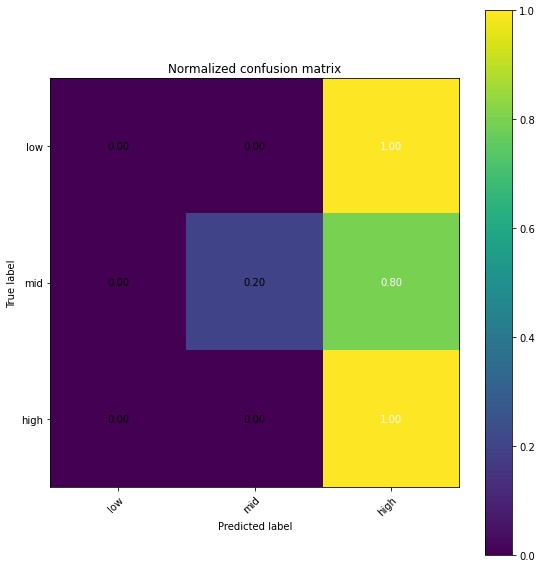

In [29]:
class_names=np.array(["low", "mid", "high"] )

plot_conf_mat(y_test, y_pred, class_names)

You can customize the confusion matrix more. For instance you may change the size. If you have many labels, you may need to remove numbers printed.

Confusion matrix, without normalization
[[ 0  0  8]
 [ 0  2  8]
 [ 0  0 41]]


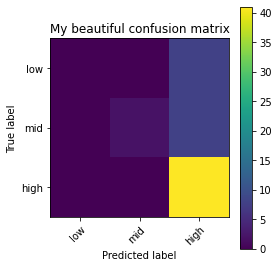

In [30]:
plot_conf_mat(y_test, y_pred, class_names, normalize=False, 
              title="My beautiful confusion matrix", cmap=plt.cm.viridis, 
              text=False, width=4, height=4)

# Class imbalance

Our dataset is quite umbalanced

In [31]:
df['res'].value_counts()

2    210
1     55
0     27
Name: res, dtype: int64

When a class is prevalent, the model adapts to that class: the result is a very bad classifier with a high accuracy. 

For instance, a silly classifier that always predicts the prevalent class would give good accuracy.

In [32]:
y_pred = [2 for i in range(len(y_test))]
accuracy_score(y_pred, y_test)

0.6949152542372882

Simple idea: In the training set, we can create synthetic samples  of the small classes, in order for all the classes to be of the same size. This is done by Synthetic Minority Over-sampling TEchnique (SMOTE):

N. V. Chawla, K. W. Bowyer, L. O.Hall, W. P. Kegelmeyer, “SMOTE: synthetic minority over-sampling technique,” Journal of artificial intelligence research, 321-357, 2002.

(**~10000 citations!**)

Synthetic samples are generated via 5-Nearest Neighbors (we'll see it later)

In [33]:
smote = SMOTE()

X_train_balanced, y_train_balanced = smote.fit_sample(X_train, y_train)
pd.value_counts(y_train_balanced)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2    169
1    169
0    169
dtype: int64

We train on the oversampled traing dataset and we test on the original test set.

Normalized confusion matrix
[[0.875      0.         0.125     ]
 [0.2        0.6        0.2       ]
 [0.34146341 0.09756098 0.56097561]]


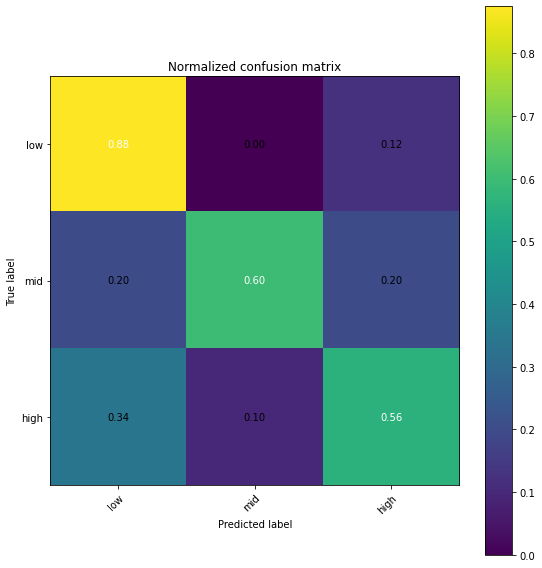

In [34]:
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
plot_conf_mat(y_test, y_pred,class_names)


In [35]:
accuracy_score(y_pred, y_test)

0.6101694915254238

We improved a bit, still the model is not excellent

Some ideas to improve it further?
<details>
<summary>
CLICK
</summary>
    
* Find the regularization weight via grid search
* Try to transform the input
* Find the best combination of features manually or via Recursive Feature Elimination
    
    
</details>

A classification report summarizes for us all the important features

In [36]:
print( classification_report(y_test, y_pred) )

              precision    recall  f1-score   support

           0       0.30      0.88      0.45         8
           1       0.60      0.60      0.60        10
           2       0.88      0.56      0.69        41

    accuracy                           0.61        59
   macro avg       0.60      0.68      0.58        59
weighted avg       0.76      0.61      0.64        59



# Grid search

Let's find the best regularization weight `C` via grid search. Let's first check what is the correct name of the parameter `C` to which we need to refer.

In [37]:
GridSearchCV(MyMultinomialRegression(), [] ).get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__standardscaler', 'estimator__logisticregression', 'estimator__standardscaler__copy', 'estimator__standardscaler__with_mean', 'estimator__standardscaler__with_std', 'estimator__logisticregression__C', 'estimator__logisticregression__class_weight', 'estimator__logisticregression__dual', 'estimator__logisticregression__fit_intercept', 'estimator__logisticregression__intercept_scaling', 'estimator__logisticregression__l1_ratio', 'estimator__logisticregression__max_iter', 'estimator__logisticregression__multi_class', 'estimator__logisticregression__n_jobs', 'estimator__logisticregression__penalty', 'estimator__logisticregression__random_state', 'estimator__logisticregression__solver', 'estimator__logisticregression__tol', 'estimator__logisticregression__verbose', 'estimator__logisticregression__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_tr

In [0]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=5)

parameters_to_test = [{ 'logisticregression__C': [1e-9, 1e-3, 0.01, 0.1, 1, 10, 100, 1000, 10000] }]

# The different scoring metrics available are in:
#     https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid = GridSearchCV(MyMultinomialRegression(), parameters_to_test, cv=k_fold, 
                    scoring='f1_macro')

In [39]:
grid.fit(X_train_balanced, y_train_balanced)
print("The best regularization weigth is ", grid.best_params_)

The best regularization weigth is  {'logisticregression__C': 0.1}


              precision    recall  f1-score   support

           0       0.28      0.88      0.42         8
           1       0.60      0.60      0.60        10
           2       0.88      0.51      0.65        41

    accuracy                           0.58        59
   macro avg       0.58      0.66      0.56        59
weighted avg       0.75      0.58      0.61        59

Normalized confusion matrix
[[0.875      0.         0.125     ]
 [0.2        0.6        0.2       ]
 [0.3902439  0.09756098 0.51219512]]


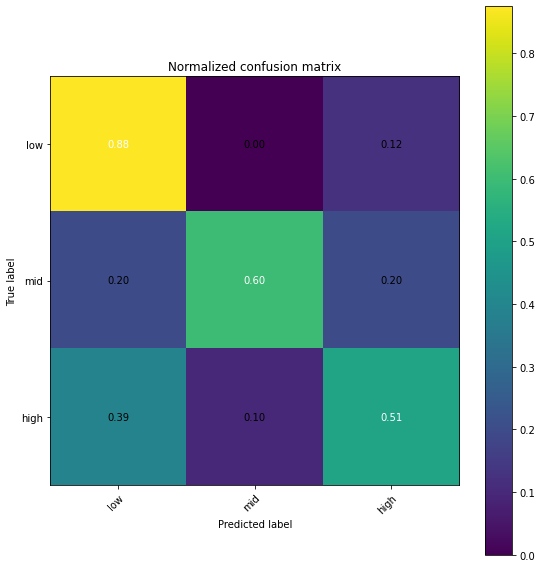

In [41]:
model = grid.best_estimator_
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_conf_mat(y_test, y_pred, class_names)

Some ideas to improve this model?
<details>
<summary>
CLICK
</summary>
    
* Since data are "squashed" towards low value => log-transformation
* Find the best combination of features manually or via Recursive Feature Elimination
    
    
</details>